Get back to the metric feature generaion over all set of electrodes. Take in account the spatial mature of data in its basic version. First, run the genetic search over all electrides, then average over neighbourhood of selected elctrodes. Then make a convolution over time and space. 

In [ ]:
%%capture
%matplotlib inline
!pip3 install pyriemann
#!pip3 install mne

In [ ]:
# --- basic and system
import numpy as np
import pandas as pd
import scipy.io as sio # Download mat files
from google.colab import drive # Mount the Google drive
from google.colab import files # Save the experimental results to the Google drive 
# import sys # To print error messages
# --- 
from sklearn.model_selection import KFold # Select
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
# ---
from sklearn import linear_model # L1
from sklearn.svm import l1_min_c
# ---
#from pyriemann.estimation import XdawnCovariances 
#from pyriemann.tangentspace import TangentSpace
# ---
from sklearn.metrics import RocCurveDisplay # Plot the ROC 
from sklearn import metrics
# ---
import matplotlib.pyplot as plt

import warnings
import datetime

Download the data

In [ ]:
drive.mount('/content/drive')
%cd  '/content/drive/MyDrive/EEG/DataMay23'
%ls

Mounted at /content/drive
/content/drive/MyDrive/EEG/DataMay23
EEG_epoch_only3responses_corrupdMay25.mat
eeg_May19.mat
eeg_May23_unfilt.mat
EEG_Recog_elAll_2000ms_Apr28updMay25.mat
EEG_Recog_elAll_800ms_Apr28updMay25.mat
Population_2023-05-29_02-01-00.xlsx
Population_2023-05-30_15-28-07.xlsx
Population_2023-05-30_15-28-47.xlsx
Population_2023-05-30_15-35-44.xlsx
Population_2023-05-30_15-39-55.xlsx
Population_2023-05-30_15-46-56.xlsx
Population_2023-05-30_15-47-25.xlsx
Population_2023-05-30_16-02-40.xlsx
Scores_2023-05-29_02-01-00.xlsx
Scores_2023-05-30_15-28-07.xlsx
Scores_2023-05-30_15-28-47.xlsx
Scores_2023-05-30_15-35-44.xlsx
Scores_2023-05-30_15-39-55.xlsx
Scores_2023-05-30_15-46-56.xlsx
Scores_2023-05-30_15-47-25.xlsx
Scores_2023-05-30_16-02-40.xlsx
UMN_Recog_elAll_1800ms_Apr28updMay25.mat
UMN_Recog_elAll_800ms_Apr28updMay25.mat


In [ ]:
# S3 dataset, the variables:
# 1) dataX, dataY, Users, timeY for each user assigned to each event
# 2) timeX, nameElec, posElec   for all users, the experiment setup 
mat_fnames = (
    'EEG_epoch_only3responses_corrupdMay25.mat',
    'eeg_May19.mat',
    'eeg_May23_unfilt.mat',
    'EEG_Recog_elAll_2000ms_Apr28updMay25.mat',
    'EEG_Recog_elAll_800ms_Apr28updMay25.mat',
    'UMN_Recog_elAll_1800ms_Apr28updMay25.mat',
    'UMN_Recog_elAll_800ms_Apr28updMay25.mat',
    )
mat_fname = mat_fnames[0] #_unfilt.mat'#'eeg_May19.mat'
mat_contents = sio.loadmat(mat_fname)
dataX = mat_contents['dataX']                   # The design matrix Events x Electrodes x Time
dataY = np.squeeze(mat_contents['dataY'])       # A class for each Event
dataU = np.squeeze(mat_contents['dataU'])       # A username for each Event
# timeY = mat_contents['timeY'] # Not needed here
# Predefined indexes of columns in the dataY structure, see the Matlab part 
# List of all available users in the data
users    = np.squeeze(mat_contents['nameUsers'])
timeline = np.squeeze(mat_contents['timeX'])
# posElec = mat_contents['posElec']   # Not needed here
nameElec = mat_contents['nameElec'] # ditto
# Claffify each event (trial) as two classes Old word versus New word in the Recognition task
# print(timeline)
dataX.shape

(907, 128, 410)

In [ ]:
#print(nameElec)

Cut the time-segments for each peak P1, P2, P3, LNP as in the SchRes paper,
P1 110-160,  P2 200-410, P3 410-650, LNP 400-750. So, we have four chunks of the dataset. 

In [ ]:
peaks = np.array(
    [#[60, 999],
     [110, 160],
     [200, 410],
     [410, 650],
     [400, 750]]) * 0.001 # time in seconds
peakNames = ('P1', 'P2', 'P3', 'LNP') # 'ALL',
# Cut the piece of time over the third axis of data 
def cut_time(X, start, stop, timeline):  
  istart = int(np.searchsorted(timeline, start))
  istop  = int(np.searchsorted(timeline, stop, side='right')) #- 1
  print(f'Time: {start}, {stop}, samples {istart}, {istop}')
  segX = X[:, :, istart : istop] # Get a time-segment last
  feaX = np.average(segX, axis = 2) # Average over the last index
  return segX, feaX

Standardize the time series before the cut

In [ ]:
stdX = np.empty_like(dataX)
for i, matX in enumerate(dataX):
  stdX[i, :, :] = scale(matX, axis=1, with_mean=True, with_std=True)
# --- 
# segX1, fea = cut_time(dataX, peaks[0,0], peaks[0,1], timeline) # test

In [ ]:
fea4peaksX = np.empty((len(dataX),len(peaks)*dataX.shape[1]))
for idx, peak in enumerate(peaks):
  _, feaX = cut_time(stdX, peak[0], peak[1], timeline)
  fea4peaksX = np.concatenate((fea4peaksX, feaX), axis=1)
fea4peaksX.shape

Time: 0.11, 0.16, samples 29, 41
Time: 0.2, 0.41000000000000003, samples 52, 105
Time: 0.41000000000000003, 0.65, samples 105, 166
Time: 0.4, 0.75, samples 103, 192


(907, 1024)

In [ ]:
print(feaX.shape, fea4peaksX.shape)
dataX = fea4peaksX

(907, 128) (907, 1024)


4

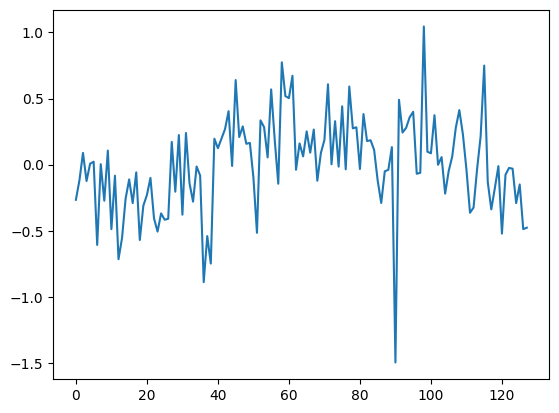

In [ ]:
plt.plot(np.average(matX[:,:], axis = 1))

Prepare the design matrix and target vector 
Four cases: 
- Correct events, All events
- Selected users, All users

Four classes map into two classes Old and New, with or without incorrect
0. Old correct
1. Old incorrect
2. New correct 
3. New incorrect


In [ ]:
users_all = np.array([1037, 1363, 2038, 7977, 1045, 1368, 6639, 7980, 1034, 1327, 1385, 7974])
users_six = np.array([1158,1045,7980,1037,6639,1363]) # Six users with higher accuracy
print(f'Selected: {np.isin(users_six, users_all)}')

class_all = np.array([0, 1, 2, 3])   # All four include incorrect responses
class_two = np.array([0, 2])         # Only correct responses
# --- Run the schedule 
users_list = (users_all, users_all, users_six, users_six)
class_list = (class_all, class_two, class_all, class_two)

# Make dataset
#idx = (np.isin(dataU, users_six)) & (np.isin(dataY, class_two))
idx = (np.isin(dataU, users_six)) & (np.isin(dataY, class_two))
Y = np.array([0 if _ <  2 else 1 for _ in dataY[idx]]) # Two classes in selected data
#X = segX1[idx]
X = dataX[idx]
#for userselect, classelect in zip (users_list, class_list):
#  # Select users and classes
#  idx = (np.isin(dataU, userselect)) & (np.isin(dataY, classelect))
#  # Make dataset
#  Y = np.array([0 if _ <  2 else 1 for _ in dataY[idx]]) # Two classes in selected data
#  X = fX[idx]
#  print(f'Users: {userselect} --- Sample size: {len(Y)} --- Class balance: {sum(Y==0)} vs {sum(Y==1)}') # --- Events: {set(Y)} 
#  select_features(X,Y)
#  classify(X, Y, names, classifiers)

Selected: [False  True  True  True  True  True]


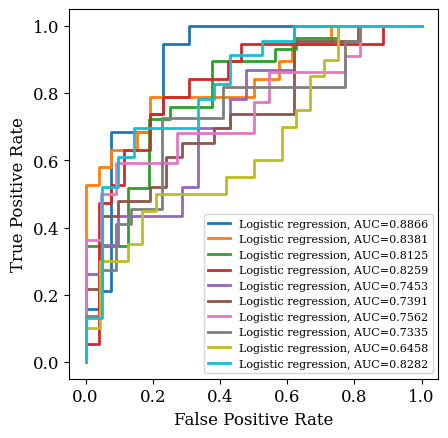

In [ ]:
name = 'Logistic regression'
cv = KFold(n_splits=10, shuffle=True, random_state=43)
n_components=5
clf = make_pipeline(
    XdawnCovariances(n_components),
    TangentSpace(metric="riemann"),   
    LogisticRegression(),
    )
preds = np.zeros(len(Y))
for train_idx, test_idx in cv.split(X):
  y_train, y_test = Y[train_idx], Y[test_idx]
  clf.fit(X[train_idx], y_train)
  # preds[test_idx] = clf.predict(X[test_idx])  
  preds[test_idx] = clf.predict_proba(X[test_idx])[::,1] # Probabilty for AUC
  fpr, tpr, _ = metrics.roc_curve(Y[test_idx], preds[test_idx])
  auc = round(metrics.roc_auc_score(Y[test_idx], preds[test_idx]), 4)
  plt.plot(fpr,tpr,label=name+", AUC="+str(auc))
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
#plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 12#24
plt.rcParams['ytick.labelsize'] = 12#24
plt.rcParams['legend.fontsize'] = 8#24
#plt.rcParams['axes.titlesize'] = 36. 
plt.rcParams['axes.labelsize'] = 12#24
plt.gca().set_aspect('equal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
def one_cls(X, Y, clf):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    clf.fit(X_train, y_train)
  #preds = clf.predict_proba(X)[::,1] # Probabilty for AUC
  preds = clf.predict(X_test)  
  acc = np.mean(preds == y_test)
#  print(f'Accur = {acc}')
  return acc
#  ----------------------------- ---------------------------------
def create_population(n_Features, POP_SIZE, K_BEST):
  # Create a random population to start with 
  population = np.empty([POP_SIZE, K_BEST], dtype=int)
  for i in range(POP_SIZE):
    population[i, :] = np.random.choice(range(n_Features), size=K_BEST, replace=False)
  scores =  np.zeros(POP_SIZE) # There is no need to evaluate now (the bigger the better)
  return(population, scores)
#  ----------------------------- ---------------------------------
def cross_mutate(population, n_Features, MUT_PROB):
  offspring = np.empty_like(population)
  # First genetic step is to crossover all members of the population
  for idx, mom  in enumerate(population):           # For each mom
    dad = population[np.random.choice(len(population)), :] # Get a random dad
    kBest = population.shape[1]
    rnd = np.random.choice(kBest)                  # Pick some chromosomes
    kid = np.concatenate((mom[:rnd], dad[-(kBest-rnd):])) # Make a kid
    offspring[idx, :] = kid                         # Put it to new tribe
    #print(idx, rnd, mom, dad, kid)
  # Second genetic step is to mutate each member of the new population
  for idx, kid  in enumerate(offspring):
    mutation = np.random.choice([0, 1], size=kBest, p=[MUT_PROB, 1-MUT_PROB]) # Set random chromosomes
    unused = np.setdiff1d(np.arange(n_Features), kid)  # Find the new chromosomes
    if len(unused) >= np.sum(mutation):                # is there enough new chromosomes
      deviation = np.random.choice(unused, size=np.sum(mutation), replace=False)  # select a few
      #oldkid = np.array(kid) # debug
      _ = np.where(mutation == 1)[0]
      kid[_] = deviation
      #print(mutation, oldkid,  kid, deviation) # debug
    else:
      print('Mutation rate is too high') # Let the kid be same
    offspring[idx, :] = kid # Put mutated kid back to tribe
  return offspring
#  ----------------------------- ---------------------------------
def offspring_evaluate(X,Y, clf, offspring):
  scores_offspring = np.zeros(len(offspring))
  # Third genetic step is to evaluate the quality of each member
  for idx, kid in enumerate(offspring):
    X_cut = X[:, kid]
    acc = one_cls(X_cut, Y, clf)
    scores_offspring[idx] = acc # Evaluate each member of the offspring
  return scores_offspring
#  ----------------------------- ---------------------------------
def population_sort(population, offspring, scores, scores_offspring):
  # Join the old tribe and the offspring tribe
  population = np.concatenate((population, offspring), axis=0)
  scores     = np.concatenate((scores, scores_offspring), axis = 0)
  idx = np.argsort(-scores)[:len(scores_offspring)] # The bigger score the better
  scores     = scores[idx]  # Keep the best scores (cut to offspring size)
  population = population[idx,:] # Select the best members 
  return population, scores
#  ----------------------------- ---------------------------------
def update_score_stat(population, scores, topM_score, topM_feat):
  # Statistics each round for the best one and the population
  for i, _ in enumerate(topM_score):
    topM_score[i] = scores[i] 
    kid = population[i, :]  # Just copy the first M scores to save
    # kid = np.array([3,4,5],  dtype=int) # Just for test
    topM_feat[i, kid] += 1  # Increase frequency of each selected feature
  return topM_score, topM_feat
#  ----------------------------- ---------------------------------
def save_population(population, scores):
  # Since genetics take long time, it is important to save the intermediate results
  df_population = pd.DataFrame(population)      # Save the population with the features
  df_scores     = pd.DataFrame(scores)          # Save the scores to start from
  now = datetime.datetime.now()                 # Get today' time to make the filename
  date_time_str = now.strftime("%Y-%m-%d_%H-%M-%S") # Format it

  fn_population = f'Population_{date_time_str}.xlsx'
  fn_scores     = f'Scores_{date_time_str}.xlsx'
  df_population.to_excel(fn_population, index=False) # Save to an Excel file
  df_scores.to_excel(fn_scores, index=False)
  files.download(fn_population)
  files.download(fn_scores)
  return
#  ----------------------------- ---------------------------------
def print_statistics(frequencies, labels): # The last is not used
  # Print the names of the most frequest featues and their occurance
  # Thanks of ChatGPT
  zipped = zip(frequencies, labels) # Each feature has its frequency
  sorted_zipped = sorted(zipped, reverse=True) # Sort to show the best
  # Unzip the sorted zipped array
  sorted_frequencies, sorted_labels = zip(*sorted_zipped)
  # Print the sorted frequencies and labels
  # print("Sorted Frequencies:", sorted_frequencies)
  # print("Sorted Labels:", sorted_labels)
  for frequency, label in sorted_zipped:
        print((label, frequency))
  return
#  ----------------------------- ---------------------------------
#  ----------------------------- ---------------------------------
#  ----------------------------- ---------------------------------  

In [ ]:
X = fea4peaksX[idx]
Y = dataY[idx]

In [ ]:
Y.shape

(444,)

In [ ]:
# Data loading 
nameFeatures = ('A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32')
# Block of the plain logistic regresson
#-----------------------------------
# nameFeatures = ['F' + str(i) for i in range(len(nameFeatures))] # Replace the original names
namePeaks = ('P1', 'P2', 'P3', 'LNP') 
grid1, grid2 = np.meshgrid(nameFeatures, namePeaks) # Create meshgrid
nameFeatures = np.reshape(np.stack((grid1, grid2), axis=-1), (-1, 2)) # Flatten the grids into one axis
nameFeatures = [' '.join((nameFeatures[i,0], nameFeatures[i,1])) for i in range(len(nameFeatures))]
X = fea4peaksX[idx]
Y = dataY[idx]
clf = LogisticRegression()
#-----------------------------------
#X = dataX[idx]
#Y = dataY[idx]
#n_components=5
#clf = make_pipeline(
#    XdawnCovariances(n_components),
#    TangentSpace(metric="riemann"),   
#    LogisticRegression(),
#    )
#-----------------------------------
# Main part of genetic search
n_Features = len(nameFeatures)
# Genetic algorithm metaparameters
K_BEST =  16     # Number of resulting features 
M_BEST = 3      # Number of rhe best models
POP_SIZE = 14   # Number of variuos models min = M_BEST
MUT_PROB = 2*1/K_BEST  # Chance of mutation for each feature
MAX_ITER = 10000   # Times POP_SIZE equals number of fits
# ---
# Statistics each round for the best one and the population
topM_score = np.zeros(M_BEST)
topM_feat  = np.zeros([M_BEST,n_Features])
# ---
# Main loop of the genetic algorithm
population, scores  = create_population(n_Features, POP_SIZE, K_BEST)
for i in range(MAX_ITER):
  offspring           = cross_mutate(population, n_Features, MUT_PROB)
  scores_offspring    = offspring_evaluate(X,Y, clf, offspring)
  population, scores  = population_sort(population, offspring, scores, scores_offspring)
  topM_score, topM_feat = update_score_stat(population, scores, topM_score, topM_feat)
  # save_population(population, scores)
  print(f'Iteration: {i}, score of best: {topM_score[1]}, features: {topM_feat[1,:]}')
  print(f'Scores: {scores}')
  # print_statistics(topM_feat[0, :], nameFeatures, K_BEST)
# Save and show results
save_population(population, scores)
print_statistics(topM_feat[1], nameFeatures)

In [ ]:
nameFeatures = ('A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32')
namePeaks = ('P1', 'P2', 'P3', 'LNP')
# Create meshgrid
grid1, grid2 = np.meshgrid(nameFeatures, namePeaks)
# Flatten the grids into one axis
nameGrid = np.reshape(np.stack((grid1, grid2), axis=-1), (-1, 2))
print(nameGrid)

In [ ]:
# Data preparation---
# WARNING! This does not work in one run.
tempX = X #dataX[idx,:]
tempY = Y #dataY[idx]
# Prepocessing gould make NaN values
nan_mask = np.isnan(tempX).any(axis=1)
tempX = tempX[~nan_mask,:]
tempY = tempY[~nan_mask]
# Subset 1
X1 = tempX[0:300, :]
Y1 = tempY[0:300]
# Subset 2
X2 = tempX[200:443, :]
Y2 = tempY[200:443]

# --- Classification with L1 regularization
cs = l1_min_c(X, Y, loss="log") * np.logspace(0, 7, 16)

clf = linear_model.LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)
coefs_ = []
# np.set_printoptions(threshold=np.inf)
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, Y)
    coefs_.append(clf.coef_.ravel().copy())
    #c_to_print = (clf.coef_.ravel().copy())
    #print(f'{c_to_print}')

#--- Plot the regularization path
coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()


#--- Correlation between elements of the regularization paths
coefs1 = coefs_ 
coefs2 = coefs_ 

for c1, c2 in zip(coefs1, coefs2):
  correlation = np.corrcoef(c2, c1)[0, 1]
  print(f'{np.round(correlation,2)}') 


(512, 2)